<a href="https://colab.research.google.com/github/Christoforos00/NLP_project/blob/main/nlp_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
import numpy as np
import pickle




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_json('/content/drive/My Drive/News_Category_Dataset_v2.json', lines=True)

In [ ]:
df

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[:100000]

In [ ]:
df['text'] = df['headline'] + " " + df['short_description']
texts = df['text'].tolist() 
labels = df['category'].tolist()


# Νέα ενότητα

In [ ]:
del df

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe(nlp.create_pipe('sentencizer')) 

def tokenize_samples(samples):
  
    tokenized_samples = []
    for i in range(len(samples)):  # For each sample
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:  # For each sentence
            for tok in sent:  # Iterate through each token 
                # Preprocessing: Filter stopwords
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
                    continue
                if tok.text.strip():  
                    tokens.append(tok.text.replace('"',"'").strip())
        tokenized_samples.append(tokens)

    return tokenized_samples

texts_tokenized = tokenize_samples(texts)
text_edited = texts_tokenized
texts_tokenized = None

In [ ]:

nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
text_edited = []

for text in texts: 

    # Remove all the special characters
    text = re.sub('\W', ' ', str(text))
    
    # Remove \n
    text = re.sub('\s+[\\n\\r]+', '', text)
   
    # Remove all single characters
    text = re.sub('\s+[a-zA-Z]\s+', ' ', text)

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Split the documents based on whitespace 
    text = text.split()

    # Lemmatization
    text = [stemmer.lemmatize(word) for word in text]

    # Reconstruct the document by joining the words on each whitespace
    text = ' '.join(text)

    text_edited.append(text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(text_edited, labels, test_size=0.2, random_state=101)

In [ ]:
# Load/deserialize
fasttext_embed = np.load("/content/drive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/drive/My Drive/fasttext_voc.pkl", 'rb'))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 250 
EMBEDDING_DIM = fasttext_embed.shape[1]

# Init tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer
tokenizer.fit_on_texts([" ".join(x) for x in X_train])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test])

# Pads sequences to a fixed value
X_train = pad_sequences(sequences=train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(sequences=test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Exclude stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Vectorize the text
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Use unigram & bi-gram tf*idf features
    max_features = 5000,  # Keep top 5000 features 
    sublinear_tf=True,  # Replace tf with 1 + log(tf)
    stop_words=stopwords.words('english'))  # Remove stopwords

# Fit Vectorizer on train data
# Transform on all data
X_train = vectorizer.fit_transform(X_train) 
X_test = vectorizer.transform(X_test)

print(vectorizer.get_feature_names())

In [ ]:
del text_edited
del labels


y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
# y_dev = lb.transform(y_dev)
y_test = lb.transform(y_test)

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=101)


In [ ]:
y_train_nonbinary = lb.inverse_transform(y_train)
y_dev_nonbinary = lb.inverse_transform(y_dev)
y_test_nonbinary = lb.inverse_transform(y_test )


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay


In [ ]:
print("Results of the majority classifier")

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train_nonbinary)

print("Classification report on the training data:")
predictions_train = baseline.predict(X_train)
print(classification_report(y_train_nonbinary, predictions_train))

print("Classification report on the development data:")
predictions_dev = baseline.predict(X_dev)
print(classification_report(y_dev_nonbinary, predictions_dev))

print("Classification report on the test data:")
predictions_test = baseline.predict(X_test)
print(classification_report(y_test_nonbinary, predictions_test))



Results of the majority classifier
Classification report on the training data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       479
ARTS & CULTURE       0.00      0.00      0.00       387
  BLACK VOICES       0.00      0.00      0.00      1419
      BUSINESS       0.00      0.00      0.00      1791
       COLLEGE       0.00      0.00      0.00       344
        COMEDY       0.00      0.00      0.00      1488
         CRIME       0.00      0.00      0.00      1054
CULTURE & ARTS       0.00      0.00      0.00       297
       DIVORCE       0.00      0.00      0.00      1025
     EDUCATION       0.00      0.00      0.00       285
 ENTERTAINMENT       0.00      0.00      0.00      4864
   ENVIRONMENT       0.00      0.00      0.00       408
         FIFTY       0.00      0.00      0.00       420
  FOOD & DRINK       0.00      0.00      0.00      1827
     GOOD NEWS       0.00      0.00      0.00       381
         GREEN       0.00      0.00      0.00       767
HEALTHY LIVING       0.00      0.00      0.00  

In [ ]:
print("Results of logistic regression")

logReg = LogisticRegression(solver="liblinear", C = 10)
logReg.fit(X_train, y_train_nonbinary)

print("Classification report on the training data:")
predictions_train = logReg.predict(X_train)
print(classification_report(y_train_nonbinary, predictions_train))

print("Classification report on the development data:")
predictions_dev = logReg.predict(X_dev)
print(classification_report(y_dev_nonbinary, predictions_dev))

print("Classification report on the test data:")
predictions_test = logReg.predict(X_test)
print(classification_report(y_test_nonbinary, predictions_test))


Results of logistic regression
Classification report on the training data:
                precision    recall  f1-score   support

          ARTS       0.47      0.18      0.26       457
ARTS & CULTURE       0.46      0.16      0.23       411
  BLACK VOICES       0.49      0.27      0.35      1375
      BUSINESS       0.47      0.42      0.45      1756
       COLLEGE       0.49      0.33      0.39       368
        COMEDY       0.53      0.30      0.38      1576
         CRIME       0.56      0.55      0.55      1010
CULTURE & ARTS       0.63      0.24      0.35       331
       DIVORCE       0.78      0.64      0.70      1003
     EDUCATION       0.53      0.33      0.41       302
 ENTERTAINMENT       0.46      0.70      0.55      4868
   ENVIRONMENT       0.72      0.18      0.28       410
         FIFTY       0.39      0.07      0.11       399
  FOOD & DRINK       0.59      0.71      0.64      1916
     GOOD NEWS       0.49      0.18      0.26       439
         GREEN       0.45   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding,Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 97 kB 2.7 MB/s 


In [ ]:
#hyperparameter tuning

def build_model(hp):
    model = keras.Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
            ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(layers.Dense(units=hp.Int('input_units' , min_value=64, max_value=512, step=128),input_shape= X_test[1].shape , activation='relu'))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=512, step=128), activation='relu'))
        model.add(Dropout(0.5))
   
    model.add(Dense(y_dev.shape[1],activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics=["accuracy"]
    )
    return model


from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=40,
    executions_per_trial=2,
    overwrite=True )

tuner.search_space_summary()



Search space summary
Default search space size: 4
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 128, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
with tf.device('/device:GPU:0'):  
    tuner.search(X_train, y_train,
                epochs=20,
                batch_size = 256,
                validation_data=(X_dev, y_dev))

Trial 8 Complete [00h 53m 46s]
accuracy: 0.4978000074625015

Best accuracy So Far: 0.5304000079631805
Total elapsed time: 02h 55m 11s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
input_units       |192               |320               
num_layers        |1                 |3                 
units_0           |448               |64                
learning_rate     |0.001             |0.001             
units_1           |320               |64                
units_2           |320               |64                

Epoch 1/20
235/235 [==============================] - 125s 529ms/step - loss: 2.4564 - accuracy: 0.3775 - val_loss: 1.9006 - val_accuracy: 0.4903
Epoch 2/20
235/235 [==============================] - 124s 527ms/step - loss: 1.8725 - accuracy: 0.4919 - val_loss: 1.7392 - val_accuracy: 0.5270
Epoch 3/20
235/235 [==============================] - 126s 537ms/step - loss: 1.6735 - accuracy: 0.5342 - val_loss: 1.6702 - val_accuracy: 0.5414
E

In [ ]:
tuner.results_summary()

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unknown)

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

Found 59278 unique tokens.


In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 250 
EMBEDDING_DIM = fasttext_embed.shape[1]

with tf.device('/device:GPU:0'):  
    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
                ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(448, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    print(model.summary())
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy'])
    
    
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
        
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )
    
    history= model.fit(
        X_train,
        y_train,
        validation_data= (X_dev, y_dev),
        batch_size=256,
        epochs=30,
        shuffle=True,
        callbacks=[Metrics(valid_data=(X_dev, y_dev)), checkpoint]
    )



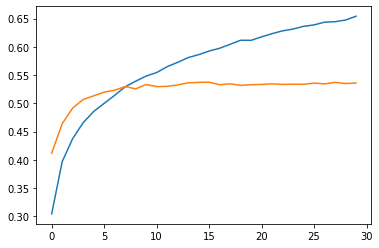

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
                ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(448, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1],activation='softmax'))


    # Load weights from the pre-trained model
    model.load_weights("checkpoints/weights.hdf5")

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=["categorical_crossentropy"]
    )

    print("Classification report on the training data:")
    predictions_train = model.predict(X_train)
    predictions_train = (predictions_train > 0.5).astype(int)   
    print(classification_report(y_train, predictions_train, target_names=lb.classes_))

    print("Classification report on the development data:")
    predictions_dev = model.predict(X_dev)
    predictions_dev = (predictions_dev > 0.5).astype(int) 
    print(classification_report(y_dev, predictions_dev, target_names=lb.classes_))

    print("Classification report on the test data:")
    predictions_test = model.predict(X_test)
    predictions_test = (predictions_test > 0.5).astype(int)    
    print(classification_report(y_test, predictions_test, target_names=lb.classes_))

Classification report on the training data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.95      0.37      0.53       468
ARTS & CULTURE       0.00      0.00      0.00       394
  BLACK VOICES       1.00      0.11      0.19      1313
      BUSINESS       0.96      0.46      0.62      1747
       COLLEGE       0.83      0.01      0.03       348
        COMEDY       0.88      0.38      0.53      1591
         CRIME       0.92      0.64      0.76      1065
CULTURE & ARTS       0.91      0.38      0.54       320
       DIVORCE       0.92      0.79      0.85      1017
     EDUCATION       0.96      0.07      0.14       294
 ENTERTAINMENT       0.89      0.69      0.78      4743
   ENVIRONMENT       1.00      0.31      0.48       408
         FIFTY       1.00      0.22      0.37       412
  FOOD & DRINK       0.77      0.89      0.83      1873
     GOOD NEWS       0.00      0.00      0.00       416
         GREEN       0.87      0.39      0.54       813
HEALTHY LIVING       0.90      0.33      0.49  